# Imports

In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [371]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [372]:
from datasets import load_dataset

# Load

In [373]:
data = load_dataset("adarshzolekar/foods-nutrition-dataset")

## Dataset preview

In [374]:
data

DatasetDict({
    train: Dataset({
        features: ['Food Items', 'Energy kcal', 'Carbs', 'Protein(g)', 'Fat(g)', 'Freesugar(g)', 'Fibre(g)', 'Cholestrol(mg)', 'Calcium(mg)'],
        num_rows: 1028
    })
})

In [375]:
df: pd.DataFrame = data["train"].to_pandas()
df

,Food Items,Energy kcal,Carbs,Protein(g),Fat(g),Freesugar(g),Fibre(g),Cholestrol(mg),Calcium(mg)
0,Butternaan,300.00,50.00,7.00,10.00,2.00,2.00,15.0,50.00
1,Cupcake,200.00,30.00,2.00,8.00,20.00,0.50,20.0,20.00
2,Donuts,250.00,30.00,3.00,12.00,10.00,1.00,20.0,20.00
3,French Fries,312.00,41.00,3.40,15.00,0.30,3.80,0.0,20.00
4,Garlic Bread,200.00,25.00,4.00,10.00,1.00,1.00,10.0,30.00
...,...,...,...,...,...,...,...,...,...
1023,Sweet and sour tomato pickle (Khatta meetha ta...,60.88,6.55,1.26,3.24,4.31,2.20,0.0,15.18
1024,Jhatpat achar with carrot (Jhatpat achaar gaja...,91.21,6.32,1.98,6.55,3.04,5.08,0.0,54.31
1025,Tomato chutney (Tamatar ki chutney),176.07,31.85,0.97,6.01,30.02,1.49,0.0,25.34
1026,Tomato ketchup,33.07,6.48,0.91,0.30,4.68,1.90,0.0,15.33


In [376]:
df.isna().sum()

Food Items        0
Energy kcal       0
Carbs             0
Protein(g)        0
Fat(g)            0
Freesugar(g)      0
Fibre(g)          0
Cholestrol(mg)    0
Calcium(mg)       0
dtype: int64

Пропусков нет

# Preparation

In [377]:
def columns_manipulation(method, columns: list[str], *dfs: pd.DataFrame):
    results = []
    for col in columns:
        print(f"\n=== Column preparation {col} ===")
        results.append(method(col, *dfs))
    return results

# Clear

In [378]:
cols_to_clear = [
    "Energy kcal",
    "Carbs",
    "Protein(g)",
    "Fat(g)",
    "Freesugar(g)",
    "Fibre(g)",
    "Cholestrol(mg)",
    "Calcium(mg)",
]

In [379]:
def clear_columns(method, columns: list[str], df_to_clean: pd.DataFrame):
    df_to_clean = columns_manipulation(method, columns, df_to_clean)[0]

## Quantile

### Funcs

In [380]:
def clear_column_quantile(col, data):

    # data = data[0]

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Q1: {Q1}")
    print(f"Q3: {Q3}")
    print(f"IQR: {IQR}")
    print(f"Lower border: {lower_bound}")
    print(f"Upper border: {upper_bound}")

    outliers_iqr = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

    print()
    print(f"Count throwable IQR: {len(outliers_iqr)}")

    data_copy = data.copy()
    data_copy[col] = data_copy[col]

    data_copy.loc[data_copy[col] > upper_bound, col] = upper_bound
    data_copy.loc[data_copy[col] < lower_bound, col] = lower_bound

    return data_copy

### Cleaning

In [381]:
df_quantile = df.copy()

In [382]:
clear_columns(clear_column_quantile, cols_to_clear, df_quantile)


=== Column preparation Energy kcal ===
Q1: 101.84
Q3: 312.91249999999997
IQR: 211.07249999999996
Lower border: -214.76874999999993
Upper border: 629.5212499999999

Count throwable IQR: 69

=== Column preparation Carbs ===
Q1: 5.6325
Q3: 27.439999999999998
IQR: 21.807499999999997
Lower border: -27.078749999999992
Upper border: 60.15124999999999

Count throwable IQR: 29

=== Column preparation Protein(g) ===
Q1: 2.1
Q3: 6.645
IQR: 4.545
Lower border: -4.717499999999999
Upper border: 13.462499999999999

Count throwable IQR: 19

=== Column preparation Fat(g) ===
Q1: 4.047499999999999
Q3: 17.075
IQR: 13.0275
Lower border: -15.493749999999999
Upper border: 36.616249999999994

Count throwable IQR: 129

=== Column preparation Freesugar(g) ===
Q1: 1.16
Q3: 11.8575
IQR: 10.6975
Lower border: -14.88625
Upper border: 27.903750000000002

Count throwable IQR: 84

=== Column preparation Fibre(g) ===
Q1: 0.59
Q3: 2.3425
IQR: 1.7525
Lower border: -2.0387500000000003
Upper border: 4.9712499999999995

C

## Z метод

### Funcs

In [383]:
Z_THRESHOLD = 1.5

In [384]:
def clear_column_z_method(col, data):
    # data = data[0]

    data_copy = data.copy()

    data_copy["Z_Score"] = np.abs(stats.zscore(data_copy[col]))

    outliers_z = data_copy[data_copy["Z_Score"] > Z_THRESHOLD]

    print(f"Count throwable by Z-Score (порог = {Z_THRESHOLD}): {len(outliers_z)}")
    print("Throwable:")
    print(outliers_z[[col, "Z_Score"]])

    return data_copy[data_copy["Z_Score"] <= Z_THRESHOLD]

### Cleaning

In [385]:
df_z_method = df.copy()

In [386]:
clear_columns(clear_column_z_method, cols_to_clear, df_quantile)


=== Column preparation Energy kcal ===
Count throwable by Z-Score (порог = 1.5): 106
Throwable:
      Energy kcal   Z_Score
110        737.63  2.698440
111        684.25  2.412206
112        710.02  2.550389
113        785.16  2.953305
114        776.74  2.908155
...           ...       ...
939        708.96  2.544705
957        774.86  2.898074
1008       610.93  2.019049
1014       736.81  2.694043
1016       552.59  1.706219

[106 rows x 2 columns]

=== Column preparation Carbs ===
Count throwable by Z-Score (порог = 1.5): 114
Throwable:
      Carbs   Z_Score
0     50.00  1.881298
130   65.08  2.783061
142   51.75  1.985945
285   44.44  1.548817
318   46.86  1.693530
...     ...       ...
999   44.95  1.579314
1000  49.94  1.877710
1012  44.50  1.552405
1017  67.95  2.954684
1020  55.51  2.210788

[114 rows x 2 columns]

=== Column preparation Protein(g) ===
Count throwable by Z-Score (порог = 1.5): 86
Throwable:
      Protein(g)   Z_Score
5          12.00  2.074994
8          20.0

## Visualisation

In [387]:
def print_boxplot(col, data, df_cleaned1, df_cleaned2):
    plt.figure(figsize=(15, 30))

    plt.subplot(8, 3, 1)

    plt.boxplot(data[col])
    plt.title(f"Boxplot before preparing ({col})")

    plt.subplot(8, 3, 2)

    plt.boxplot(df_cleaned1[col])
    plt.title(f"Boxplot with quantile ({col})")

    plt.subplot(8, 3, 3)

    plt.boxplot(df_cleaned2[col])
    plt.title(f"Boxplot with Z-method ({col})")

    plt.tight_layout()
    plt.show()


=== Column preparation Energy kcal ===


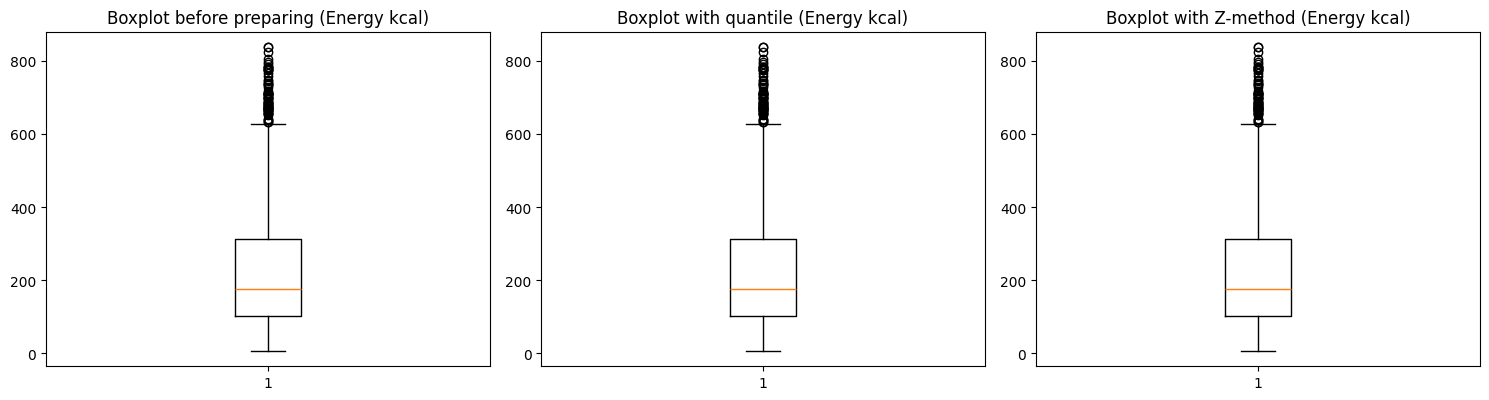


=== Column preparation Carbs ===


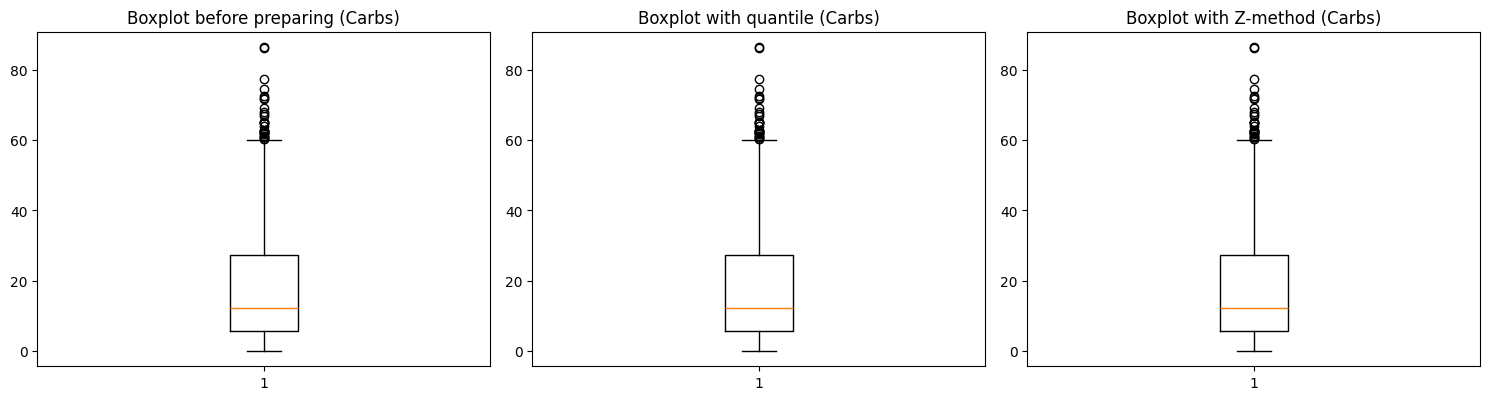


=== Column preparation Protein(g) ===


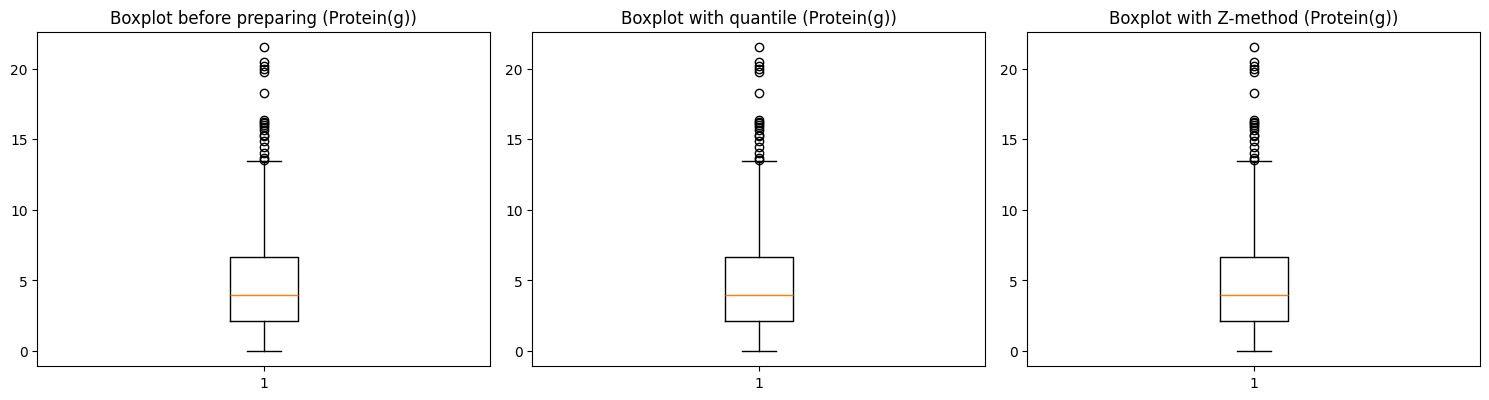


=== Column preparation Fat(g) ===


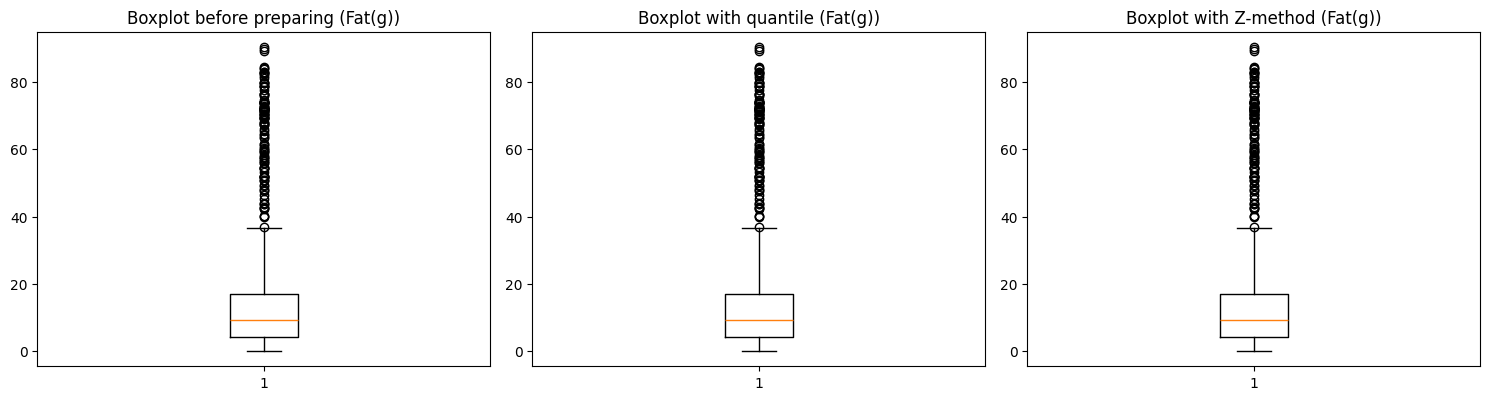


=== Column preparation Freesugar(g) ===


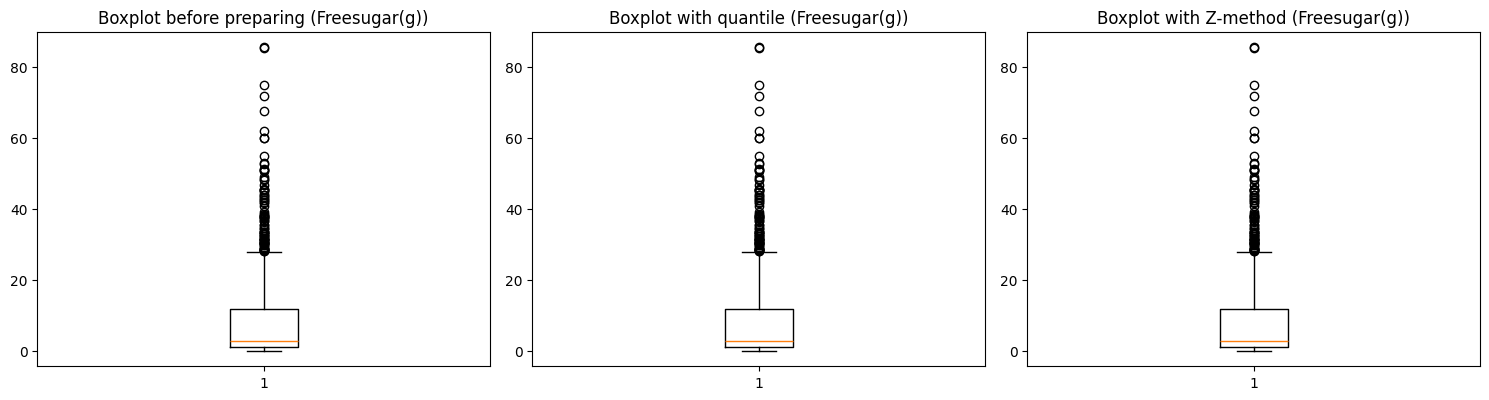


=== Column preparation Fibre(g) ===


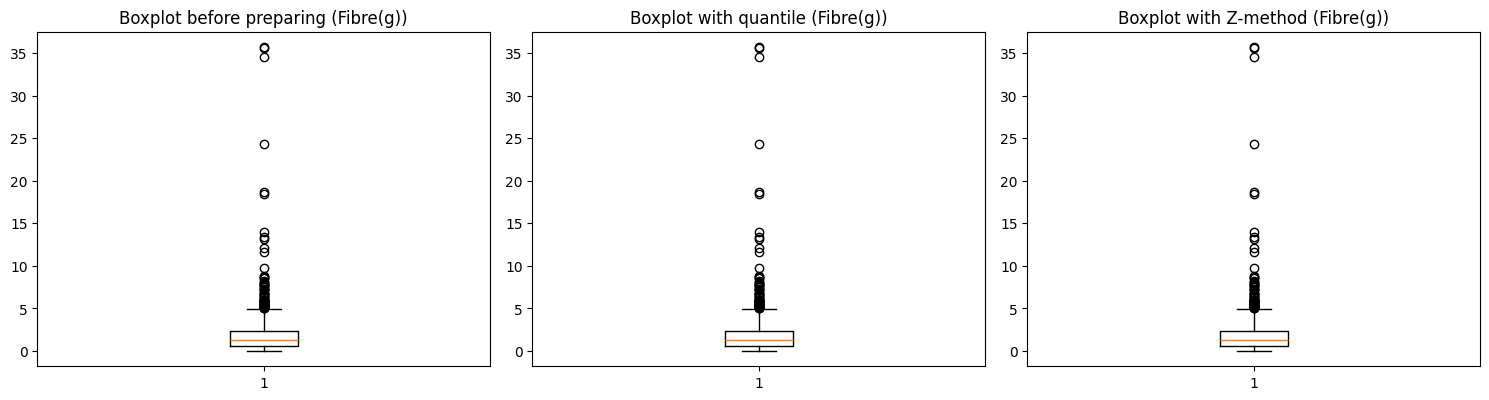


=== Column preparation Cholestrol(mg) ===


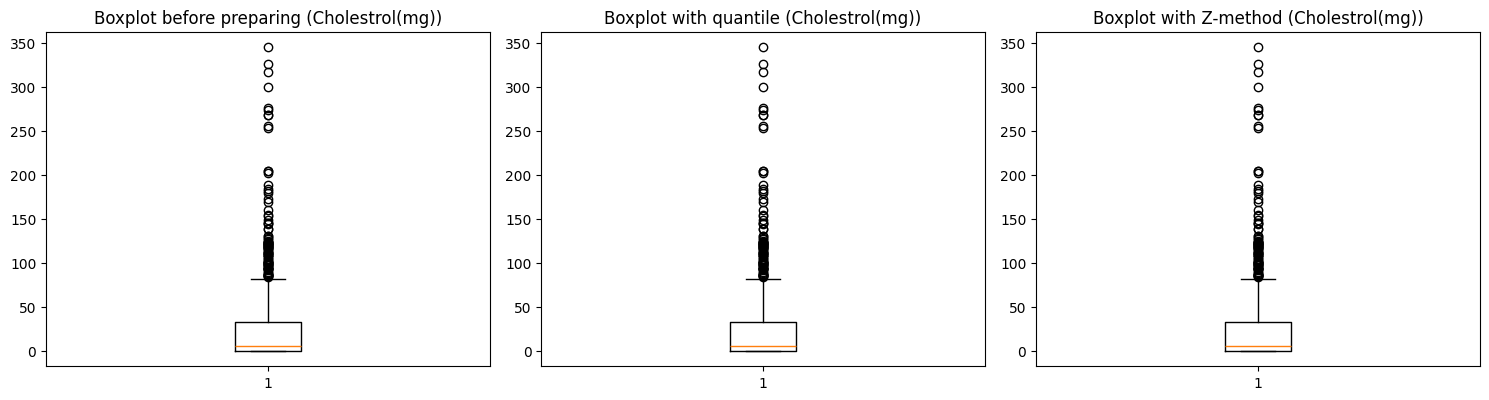


=== Column preparation Calcium(mg) ===


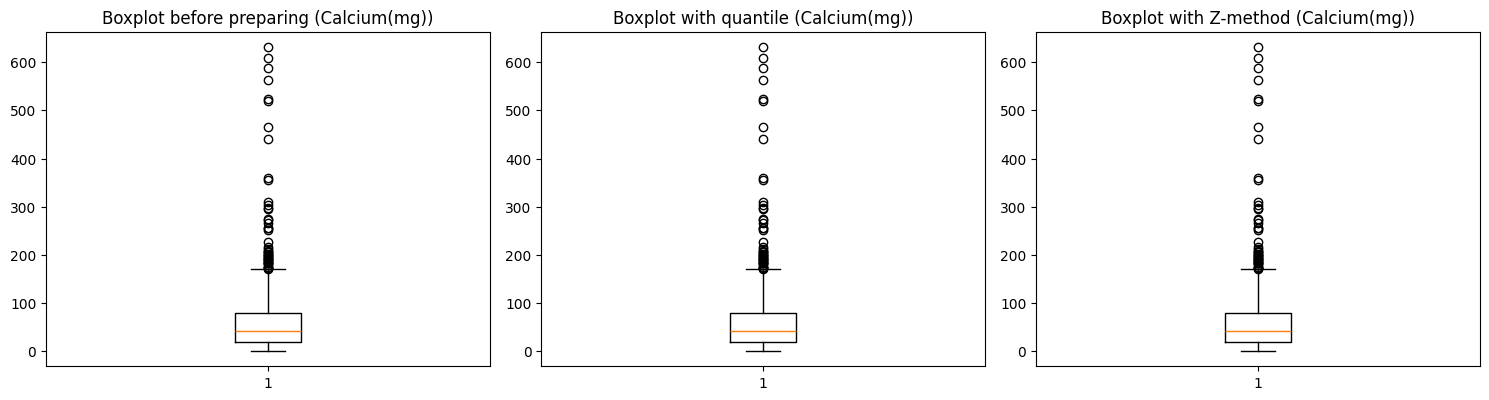

In [388]:
columns_manipulation(print_boxplot, cols_to_clear, df, df_quantile, df_z_method);

# Features selection

## Preparation

Предположим, что целевой столбец - Energy kcal

In [389]:
df_quantile.describe()

,Energy kcal,Carbs,Protein(g),Fat(g),Freesugar(g),Fibre(g),Cholestrol(mg),Calcium(mg)
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,234.396109,18.539475,4.784115,16.238317,8.813220,1.959883,25.686284,59.894329
std,186.581466,16.730920,3.479237,20.322553,12.319459,2.755564,44.742728,67.212037
min,6.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.840000,5.632500,2.100000,4.047500,1.160000,0.590000,0.000000,18.595000
50%,176.870000,12.250000,4.000000,9.270000,2.830000,1.325000,5.410000,40.795000
75%,312.912500,27.440000,6.645000,17.075000,11.857500,2.342500,33.422500,79.500000
max,839.330000,86.530000,21.550000,90.450000,85.570000,35.710000,345.880000,631.820000


Данные без пропусков, имеют достаточно большое отклонение (не константны)

In [390]:
num_columns = cols_to_clear

In [391]:
target = "Energy kcal"

Посмотрим на корреляцию между признаками

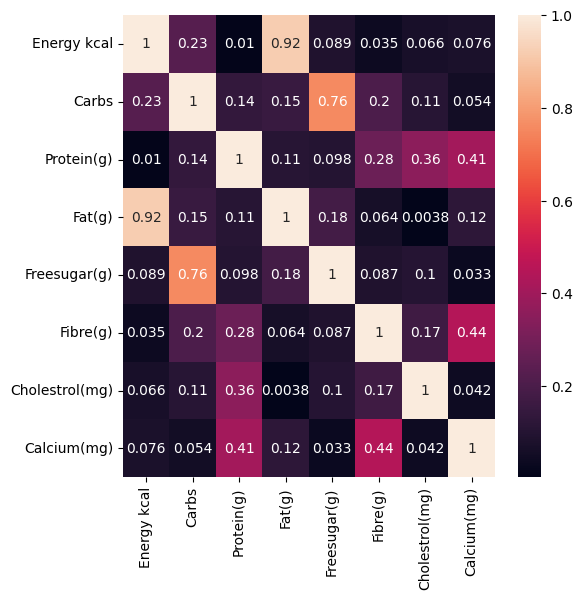

In [392]:
plt.figure(figsize=(6, 6))
sns.heatmap(np.abs(df_quantile[num_columns].corr()), annot=True)
plt.show()

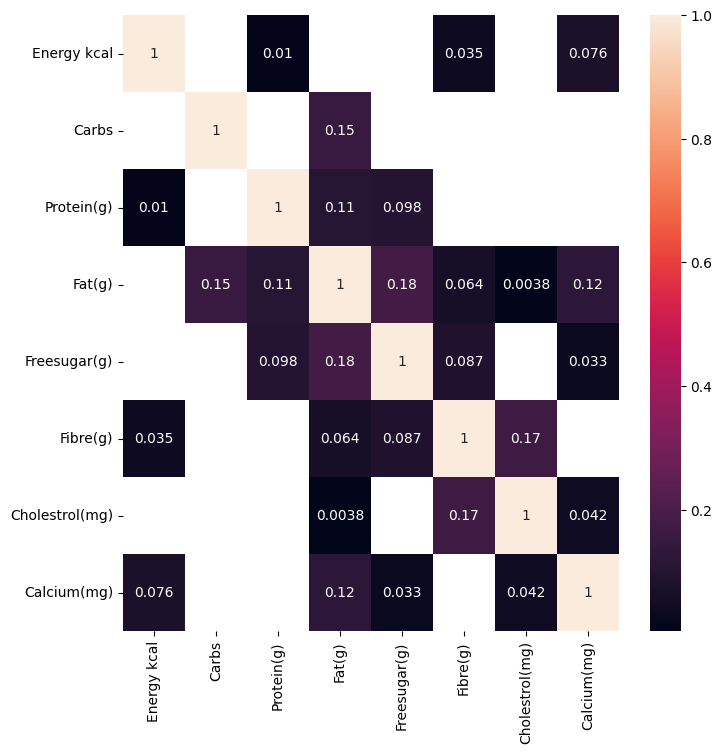

In [393]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    np.abs(
        df_quantile[num_columns].corr()[
            (
                (df_quantile[num_columns].corr() < 0.05)
                | (df_quantile[num_columns].corr() > 0.95)
            )
        ]
    ),
    annot=True,
)
plt.show()

Видим, что признаки Protein(g) и Fibre(g) имеют довольно низкую корреляцию с целевой переменной

При острой необходимости понижения размерности можно удалить, но, так как в нашем случае признаков не много, оставим

## Greedy Algorithm

In [394]:
SEED = 42

In [395]:
X = df_quantile[cols_to_clear[1:]]
y = df_quantile["Energy kcal"]

In [396]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

In [397]:
scaler = StandardScaler()

train_index = X_train.index
test_index = X_test.index
feature_columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature_columns, index=train_index)
X_test = pd.DataFrame(X_test, columns=feature_columns, index=test_index)

In [398]:
def process(X_train, X_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")

    return lr_model, mae, r2

In [399]:
available_features = list(X_train.columns)
selected_features = []
best_score = -np.inf
history = []

while available_features:
    scores = []

    # Пробуем добавить каждый доступный признак
    for feature in available_features:
        current_features = selected_features + [feature]

        # Обучаем модель с текущим набором признаков
        X_train_subset = X_train[current_features]
        X_test_subset = X_test[current_features]

        lr_model = LinearRegression()
        lr_model.fit(X_train_subset, y_train)
        y_pred = lr_model.predict(X_test_subset)

        score = r2_score(y_test, y_pred)

        scores.append((feature, score))

        print(f"Test features:\t{current_features}\tR2 = {abs(score):.4f}")

    best_feature, best_current_score = max(scores, key=lambda x: x[1])

    # Проверяем, улучшилась ли метрика достаточно сильно
    
    def has_significant_progress():
        delta = 0.001  # минимальное значимое улучшение
        return best_current_score - best_score > delta
    def has_better_score():
        return best_current_score > best_score

    if has_better_score() and has_significant_progress():

        best_score = best_current_score
        selected_features.append(best_feature)
        available_features.remove(best_feature)

        history.append(
            {
                "added_feature": best_feature,
                "features": selected_features.copy(),
                "score": abs(best_current_score),
            }
        )

        print()
        print(f"Added feature:\t{best_feature}")
        print(f"Current list:\t{selected_features}")
        print(f"Best R2:\t{best_current_score:.4f}")
        print()

    else:
        print(f"\n---No progress, exiting cycle---")
        print(f"Selected features:\t{selected_features}")
        break

Test features:	['Carbs']	R2 = 0.0611
Test features:	['Protein(g)']	R2 = 0.0003
Test features:	['Fat(g)']	R2 = 0.8534
Test features:	['Freesugar(g)']	R2 = 0.0085
Test features:	['Fibre(g)']	R2 = 0.0012
Test features:	['Cholestrol(mg)']	R2 = 0.0018
Test features:	['Calcium(mg)']	R2 = 0.0092

Added feature:	Fat(g)
Current list:	['Fat(g)']
Best R2:	0.8534

Test features:	['Fat(g)', 'Carbs']	R2 = 0.9889
Test features:	['Fat(g)', 'Protein(g)']	R2 = 0.8610
Test features:	['Fat(g)', 'Freesugar(g)']	R2 = 0.9247
Test features:	['Fat(g)', 'Fibre(g)']	R2 = 0.8640
Test features:	['Fat(g)', 'Cholestrol(mg)']	R2 = 0.8576
Test features:	['Fat(g)', 'Calcium(mg)']	R2 = 0.8563

Added feature:	Carbs
Current list:	['Fat(g)', 'Carbs']
Best R2:	0.9889

Test features:	['Fat(g)', 'Carbs', 'Protein(g)']	R2 = 0.9897
Test features:	['Fat(g)', 'Carbs', 'Freesugar(g)']	R2 = 0.9898
Test features:	['Fat(g)', 'Carbs', 'Fibre(g)']	R2 = 0.9891
Test features:	['Fat(g)', 'Carbs', 'Cholestrol(mg)']	R2 = 0.9894
Test feature